# VAR Accuracy of Mixture Models vs GARCH

In [33]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

from IPython.display import display

from pathlib import Path
import sys
import time
import os
from copy import copy

script_dir =  "../scripts"
sys.path.append(script_dir)

import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader as pdr
import numpy as np
import sklearn.mixture as mix
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
from arch import arch_model
from numba import jit
import math

from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns
savefig_kwds=dict(dpi=300, bbox_inches='tight')

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import cprint

blue, gold, green, red, purple, brown = sns.color_palette('colorblind', 6)
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-08-03T22:54:41.856141+02:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 22.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

pandas           : 1.5.3
pandas_datareader: 0.10.0
numpy            : 1.23.5
sklearn          : 1.2.2
statsmodels      : 0.14.0
scipy            : 1.10.1
matplotlib       : 3.7.1
seaborn          : 0.12.2
plotnine         : 0.12.1



In [34]:
sns_params = {
    "axes.grid": True,
    "ytick.left": True,
    "xtick.bottom": True,
    "xtick.major.size": 2,
    "ytick.major.size": 2,
    "font.size": 11,
    "font.weight": "medium",
    "figure.figsize": (10, 7),
    "font.family": "DejaVu Sans Mono",  # "Ubuntu Mono",
}

sns.set(context="poster", style="ticks", rc=sns_params)
savefig_kwds = dict(dpi=90, bbox_inches="tight", format="png")
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#f4cae4"]
sns.set_palette(sns.color_palette(flatui, 7))

## Study Design

1. choose symbol to test (stats.guassian_kde and garch are only univariate)
2. collect model functions
3. decide on frequency and sample splits
4. iterate over train, test data 
    - collect forecasts
    - compute results for forecast period
    - collect results for forecast period
5. aggregate results
6. evaluate results and plots

#### Import data

In [35]:
load_rs = '../data/etf_returns_2007-04-11-2023-07-31.csv'

rs = (pd.read_csv(load_rs, index_col=[0])) 
rs.index = pd.DatetimeIndex(rs.index) 
rs = rs.assign(year=lambda df: df.index.year)

rs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4105 entries, 2007-04-11 00:00:00+00:00 to 2023-07-31 00:00:00+00:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     4105 non-null   float64
 1   QQQ     4105 non-null   float64
 2   DIA     4105 non-null   float64
 3   TLT     4105 non-null   float64
 4   GLD     4105 non-null   float64
 5   EFA     4105 non-null   float64
 6   EEM     4105 non-null   float64
 7   BND     4105 non-null   float64
 8   VNQ     4105 non-null   float64
 9   year    4105 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 352.8 KB


In [36]:
test_symbol = 'SPY'
data = rs[test_symbol].to_frame().loc['2008':].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3921 entries, 2008-01-02 00:00:00+00:00 to 2023-07-31 00:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     3921 non-null   float64
dtypes: float64(1)
memory usage: 61.3 KB


### Collect Model Functions

In [37]:
def calc_quantile_var(data, alpha=0.05):
    """
    compute var by quantile
    """
    return data.quantile(alpha)

#### Gaussian Mixture

In [38]:
# gaussian mixture model, 2 components

def gmm(data, n_components, max_iter=150, random_state=0, **kwds):
    """
    gaussian mixture model by sklearn
    """
    model = mix.GaussianMixture(n_components, max_iter=max_iter,
                                random_state=random_state, **kwds)
    model.fit(data)
    return model

In [39]:
def gmm_sample(data, n_components=2, max_iter=150, random_state=0,
                     n_samples=1000, risky=True, **kwds):
    """
    sample from the risky component
    """
    model = gmm(data, n_components=n_components,
                max_iter=max_iter, random_state=random_state, **kwds)
    X_s, y_s = model.sample(n_samples)
    df = pd.DataFrame(X_s, columns=data.columns).assign(component=y_s)
    if not risky: 
        ser = pd.Series(X_s.ravel())
        ser.name = 'gmm'
        return ser
    
    risky = df.groupby('component').mean().mean(1).argmin()
    ser = df.query('component==@risky').set_index('component').squeeze()
    ser.name = 'gmm_risky'
    return ser
    

In [40]:
def calc_gmm_var(data, n_components=2, max_iter=150, random_state=0, 
                 n_samples=1000, risky=True, **kwds):
    """
    compute quantile var for gmm risky component
    """
    gmm_samples = gmm_sample(data, 2, risky=risky)
    return calc_quantile_var(gmm_samples)

gmm_var = calc_gmm_var(data, risky=False)
gmm_var

-0.01865220081089966

#### Garch

In [41]:
# garch model 1,0,1
def garch(data, p=1, o=0, q=1, update_freq=5, **kwds):
    model = arch_model(data, 'Garch', p=p, o=o, q=q, **kwds)
    res = model.fit(update_freq=update_freq, disp='off')
    return res

def garch_forecast_sim(data, p=1, o=0, q=1, update_freq=5,
                       horizon=30, n_simulations=1000, **kwds):
    np.random.seed(0)
    garch_model = garch(data,p=p,o=o,q=q,update_freq=update_freq) 
    forecasts = garch_model.forecast(
        horizon=horizon, method='simulation',simulations=n_simulations)
    sim_ser = pd.Series(forecasts.simulations.values[-1,:,-1])
    sim_ser.name = 'garch'    
    return sim_ser

def calc_garch_var(data, p=1, o=0, q=1, update_freq=5, horizon=30, n_simulations=1000, alpha=0.05, **kwds):
    sim_ser = garch_forecast_sim(data, p=p, o=o, q=q, update_freq=update_freq,
                                 horizon=horizon, n_simulations=n_simulations//horizon, **kwds)
    var = calc_quantile_var(sim_ser, alpha=alpha)
    return var

calc_garch_var(data, n_simulations=10000)

-0.014972429536115323

In [42]:
calc_garch_var(data, n_simulations=10000, dist='studentT')

-0.01616600927932527

#### Gaussian KDE

In [43]:
# guassian kde
def gkde(data, **kwds):
    if isinstance(data, pd.DataFrame): data=data.squeeze()
    return stats.gaussian_kde(data, **kwds)

def sample_gaussian_kde(data, n_samples=1000, **kwds):
    np.random.seed(0)
    model = gkde(data, **kwds)
    samples = model.resample(n_samples).ravel()
    ser = pd.Series(samples)
    ser.name = 'gaussian_kde'
    return ser

def calc_gaussian_kde_var(data, n_samples=1000, alpha=0.05, **kwds):
    samples = sample_gaussian_kde(data, n_samples=n_samples, **kwds)
    return calc_quantile_var(samples, alpha=alpha)

calc_gaussian_kde_var(data)

-0.01942707008401202

#### Historical 

In [44]:
# historical var

def calc_historical_var(data, alpha=0.05): 
    if isinstance(data, pd.DataFrame): data=data.squeeze()
    return calc_quantile_var(data, alpha=alpha)

calc_historical_var(data)

-0.0195714401492873

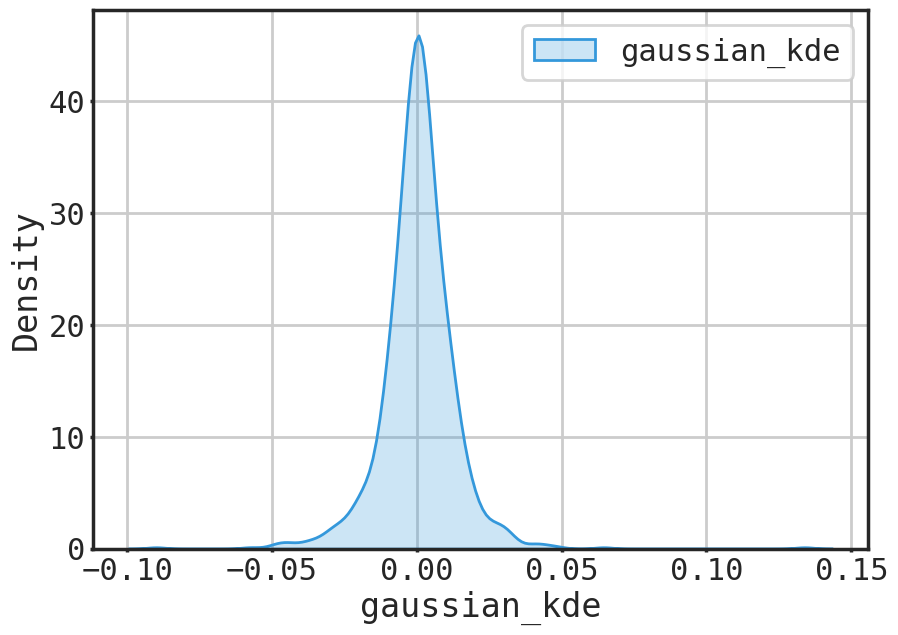

In [45]:
def plot_hist_samples(samples, ax=None):
    if not ax: ax = plt.gca()
    
    sns.distplot(samples, ax=ax, label=samples.name, 
                 hist=False, kde_kws={'shade':True})
    ax.legend()
    
plot_hist_samples(sample_gaussian_kde(data))    

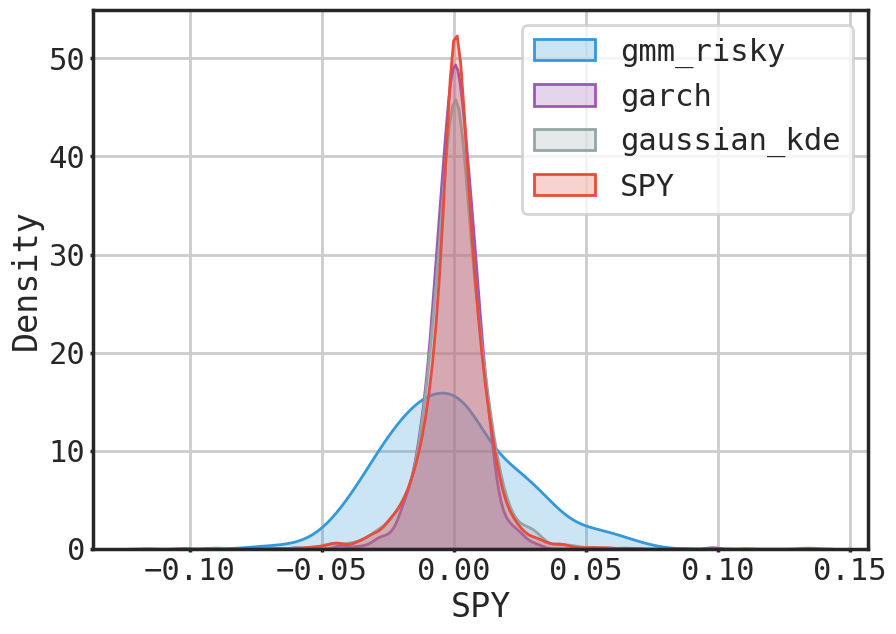

In [46]:
gmm_samples = gmm_sample(data, 2)
garch_samples = garch_forecast_sim(data)
g_kde_samples = sample_gaussian_kde(data)
hist_data = data.squeeze()

sample_series = [gmm_samples, garch_samples, g_kde_samples, hist_data]
f, ax = plt.subplots(figsize=(10,7))
for s in sample_series:
    plot_hist_samples(s, ax=ax)

## Run VAR model

In [47]:
month_index = data.resample('M').mean().index
month_index

DatetimeIndex(['2008-01-31 00:00:00+00:00', '2008-02-29 00:00:00+00:00',
               '2008-03-31 00:00:00+00:00', '2008-04-30 00:00:00+00:00',
               '2008-05-31 00:00:00+00:00', '2008-06-30 00:00:00+00:00',
               '2008-07-31 00:00:00+00:00', '2008-08-31 00:00:00+00:00',
               '2008-09-30 00:00:00+00:00', '2008-10-31 00:00:00+00:00',
               ...
               '2022-10-31 00:00:00+00:00', '2022-11-30 00:00:00+00:00',
               '2022-12-31 00:00:00+00:00', '2023-01-31 00:00:00+00:00',
               '2023-02-28 00:00:00+00:00', '2023-03-31 00:00:00+00:00',
               '2023-04-30 00:00:00+00:00', '2023-05-31 00:00:00+00:00',
               '2023-06-30 00:00:00+00:00', '2023-07-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=187, freq='M')

In [48]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

np.random.seed(0)

lookback = 252

# stash model predictions
keys = ['gmm', 'gmm_risky', 'garch_normal', 'garch_t', 'garch_skewt', 'gkde', 'historical']
predictions = dict.fromkeys(keys)

for k in predictions.keys(): predictions[k] = []

# stash actual minimum returns for next period
min_month_returns = []

### begin model code ###

for i, month_end in enumerate(month_index):
    try:
        if not data.loc[:month_end].shape[0] > lookback: continue

        train = data.loc[:month_end].iloc[-lookback:]
        test = data.loc[month_end+pd.Timedelta(days=1):month_index[i+1]]

        # calc vars
        gmm_var = calc_gmm_var(train, risky=False)
        gmm_risky_var = calc_gmm_var(train, risky=True)
        garch_norm_var = calc_garch_var(train, n_simulations=10000, dist='Normal')
        garch_t_var = calc_garch_var(train, n_simulations=10000, dist='StudentT')
        garch_skewt_var = calc_garch_var(train, n_simulations=10000, dist='skewt')
        gkde_var = calc_gaussian_kde_var(train)
        hist_var = calc_historical_var(train)    

        train_vars = [gmm_var, gmm_risky_var,
                      garch_norm_var, garch_t_var, garch_skewt_var,
                      gkde_var, hist_var]
        for k, var in zip(predictions.keys(), train_vars): predictions[k].append(var)

        min_month_returns.append(test.squeeze().min())
    except Exception as error:
        print(error)
    

index 187 is out of bounds for axis 0 with size 187


## Evaluate MAPE results

In this experiment we will use [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) to evaluate the VAR prediction results. This is a relatively easy to interpret measure of the prediction error.

In [49]:
# https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python/42251083#42251083

def mape_vectorized_v2(actual, predict): 
    mask = actual != 0
    return (np.fabs(actual - predict)/actual)[mask].mean() 

model_errors = dict.fromkeys(keys)
for k in model_errors.keys(): model_errors[k] = []
    
actual = np.asarray(min_month_returns)
for k, predict in predictions.items():
    model_errors[k].append(mape_vectorized_v2(actual, predict))

error_df = (pd.DataFrame.
            from_dict(model_errors)
            .T
            .squeeze()
            .sort_values(ascending=False)*100.)
error_df

garch_normal    -56.0508
garch_t         -56.1954
garch_skewt     -58.8320
historical      -67.3777
gmm             -68.1991
gkde            -70.7481
gmm_risky      -115.4458
Name: 0, dtype: float64

### Test model for other symbols

In [50]:
def run_model(return_dataframe, symbol, keys, lookback=252):
    
    # get data
    data = return_dataframe[symbol].to_frame().loc['2008':].copy()    
    
    np.random.seed(0)

    # stash model predictions
    predictions = dict.fromkeys(keys)
    for k in predictions.keys(): predictions[k] = []

    # stash actual minimum returns for next period
    min_month_returns = []

    ### begin model code ###

    for i, month_end in enumerate(month_index):
        sys.stdout.write('.')
        sys.stdout.flush()        
        try:
            if not data.loc[:month_end].shape[0] > lookback: continue

            train = data.loc[:month_end].iloc[-lookback:]
            test = data.loc[month_end+pd.Timedelta(days=1):month_index[i+1]]

            # calc vars
            gmm_var = calc_gmm_var(train, risky=False)
            gmm_risky_var = calc_gmm_var(train, risky=True)
            garch_norm_var = calc_garch_var(train, n_simulations=10000, dist='Normal')
            garch_t_var = calc_garch_var(train, n_simulations=10000, dist='StudentT')
            garch_skewt_var = calc_garch_var(train, n_simulations=10000, dist='skewt')
            gkde_var = calc_gaussian_kde_var(train)
            hist_var = calc_historical_var(train)    

            train_vars = [gmm_var, gmm_risky_var,
                          garch_norm_var, garch_t_var, garch_skewt_var,
                          gkde_var, hist_var]
            for k, var in zip(predictions.keys(), train_vars): predictions[k].append(var)

            min_month_returns.append(test.squeeze().min())
        except Exception as e:
            print(e)
        
    return min_month_returns, predictions

In [51]:
def calc_model_mape(actual, predictions, symbol, keys):
    # https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python/42251083#42251083

    def mape_vectorized_v2(actual, predict): 
        mask = actual != 0
        return (np.fabs(actual - predict)/actual)[mask].mean() 

    model_errors = dict.fromkeys(keys)
    for k in model_errors.keys(): model_errors[k] = []

    actual = np.asarray(min_month_returns)
    for k, predict in predictions.items():
        model_errors[k].append(mape_vectorized_v2(actual, predict))

    error_df = (pd.DataFrame.
                from_dict(model_errors)
                .T
                .squeeze()
                .sort_values(ascending=False)*100.)
    error_df.name = symbol
    return error_df    

In [52]:
errors = []
preds = dict()
actuals = dict()
for symbol in rs.columns:
    sys.stdout.write('.')
    sys.stdout.flush()    
    try:
        actual, predictions = run_model(rs, symbol, keys)
        tmp_errors = calc_model_mape(actual, predictions, symbol, keys)
        errors.append(tmp_errors)
        preds[symbol] = predictions
        actuals[symbol] = actual
    except Exception as e:
        print(e)

............................................................................................................................................................................................index 187 is out of bounds for axis 0 with size 187
.............................................................................................................................

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...............................................................index 187 is out of bounds for axis 0 with size 187
.......................................................................................................................

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.....................................................................index 187 is out of bounds for axis 0 with size 187
...........................................................................................

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



.................................................................................................index 187 is out of bounds for axis 0 with size 187
...................................................................................................

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.........................................................................................index 187 is out of bounds for axis 0 with size 187
..........................................................................................................................

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



..................................................................index 187 is out of bounds for axis 0 with size 187
............................................................................................................................................................................................index 187 is out of bounds for axis 0 with size 187
...........................

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



....

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



..........................

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



....

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.....

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



....

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



......

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



..........

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.......

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.........

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



....

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...............

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



....

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



....

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.....

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.....

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...........

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.........

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.....index 187 is out of bounds for axis 0 with size 187
............................................................................................................................................................................................index 187 is out of bounds for axis 0 with size 187
................

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.........

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.........

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



........

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
...

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



........................

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.......

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



........

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.



......

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



............

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.....................

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



.............

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.........

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.....

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



...........

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



.........

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

/Users/maximilian/miniconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



........index 187 is out of bounds for axis 0 with size 187
operands could not be broadcast together with shapes (175,) (174,) 


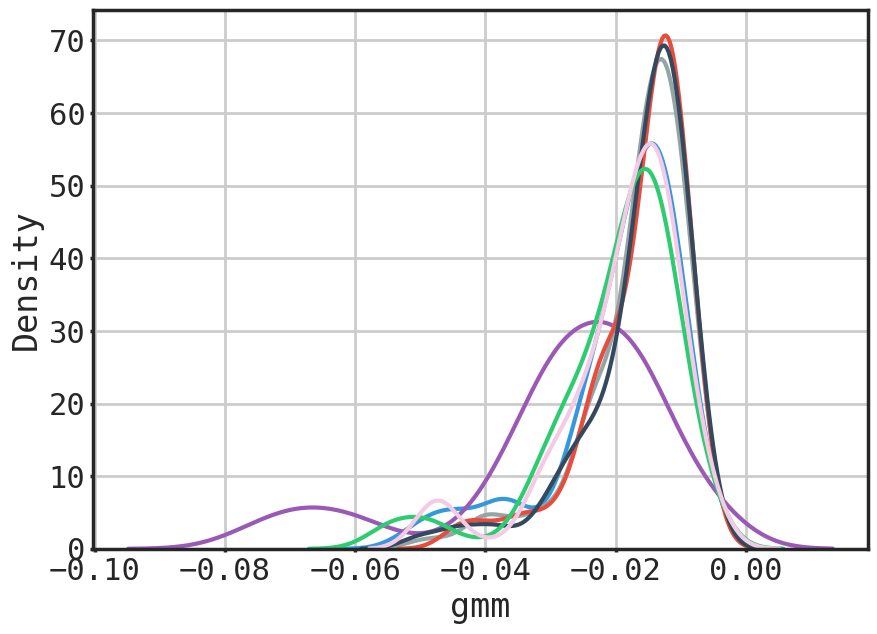

In [53]:
test = pd.DataFrame.from_dict(preds['SPY'])
for col in test.columns:
    sns.kdeplot(test[col])

In [54]:
error_df = pd.concat(errors,axis=1)    
display(error_df)

,SPY,QQQ,DIA,TLT,GLD,EFA,EEM,BND,VNQ
garch_t,-56.8223,-71.0344,-101.4202,-55.0809,-63.2163,-87.0343,-91.1458,-995.6697,-76.8420
garch_skewt,-56.9575,-68.2956,-125.5966,-54.9598,-62.9714,-85.1945,-88.6310,-963.3304,-75.5778
garch_normal,-57.9778,-68.0899,-91.7487,-54.9078,-62.3471,-87.8483,-91.6514,-980.9842,-77.4767
historical,-67.3777,-81.3073,-63.9804,-55.3640,-63.9373,-76.9352,-98.8663,-71.2527,-97.2830
gmm,-68.1991,-82.6319,-64.6636,-58.2499,-64.6038,-79.4113,-103.5520,-68.0686,-100.3696
gkde,-70.7481,-87.1318,-66.6734,-60.0023,-68.2804,-82.1333,-108.4189,-69.0909,-104.8343
gmm_risky,-115.4458,-138.1524,-108.0471,-71.3657,-102.3944,-147.3323,-157.0947,-63.4583,-149.8951


In [55]:
error_df.mean(1).sort_values()[::-1]

historical      -75.1449
gmm             -76.6389
gkde            -79.7015
gmm_risky      -117.0207
garch_normal   -174.7813
garch_skewt    -175.7238
garch_t        -177.5851
dtype: float64

In [56]:
error_df.T.describe().T.sort_values('mean')[::-1]

,count,mean,std,min,25%,50%,75%,max
historical,9.0000,-75.1449,15.0458,-98.8663,-81.3073,-71.2527,-63.9804,-55.3640
gmm,9.0000,-76.6389,16.2101,-103.5520,-82.6319,-68.1991,-64.6636,-58.2499
gkde,9.0000,-79.7015,17.3149,-108.4189,-87.1318,-70.7481,-68.2804,-60.0023
gmm_risky,9.0000,-117.0207,34.0996,-157.0947,-147.3323,-115.4458,-102.3944,-63.4583
garch_normal,9.0000,-174.7813,302.6613,-980.9842,-91.6514,-77.4767,-62.3471,-54.9078
garch_skewt,9.0000,-175.7238,296.1398,-963.3304,-88.6310,-75.5778,-62.9714,-54.9598
garch_t,9.0000,-177.5851,307.1864,-995.6697,-91.1458,-76.8420,-63.2163,-55.0809


In [57]:
error_df.T.describe().T.sort_values('50%')[::-1]

,count,mean,std,min,25%,50%,75%,max
gmm,9.0000,-76.6389,16.2101,-103.5520,-82.6319,-68.1991,-64.6636,-58.2499
gkde,9.0000,-79.7015,17.3149,-108.4189,-87.1318,-70.7481,-68.2804,-60.0023
historical,9.0000,-75.1449,15.0458,-98.8663,-81.3073,-71.2527,-63.9804,-55.3640
garch_skewt,9.0000,-175.7238,296.1398,-963.3304,-88.6310,-75.5778,-62.9714,-54.9598
garch_t,9.0000,-177.5851,307.1864,-995.6697,-91.1458,-76.8420,-63.2163,-55.0809
garch_normal,9.0000,-174.7813,302.6613,-980.9842,-91.6514,-77.4767,-62.3471,-54.9078
gmm_risky,9.0000,-117.0207,34.0996,-157.0947,-147.3323,-115.4458,-102.3944,-63.4583


## Conclusions

Surprisingly the `historical` model was the top ranked in terms of VAR accuracy when looking at the average `mape` score, followed by the full `gmm` model (using 2 components). As expected on average the `gmm_risky` is the worst performer due to the VAR being calculated using only the most volatile component.